# Imports

In [1]:
import tensorflow as tf
# from tensorflow.python.framework.ops import disable_eager_execution 
# disable_eager_execution()
# from tensorflow.python.framework.ops import enable_eager_execution
# enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
# Import common tensorflow layers and activations
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.layers import Lambda, Multiply, Add, Rescaling
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import Input

from local_tabnet import TabNet
from local_tabnet import CategoryEmbeddingShimLayer

In [3]:
BATCH_SIZE = 4096
LAMBDA = 1e-6
N_A = 16
N_D = 16
VIRTUAL_BATCH_SIZE = 1024
BATCH_MOMENTUM = 0.95
N_STEPS = 4
GAMMA = 1.5

# Data Defn

In [20]:
# Load telematics data
dataset_name = 'poker_hand'
train = pd.read_csv('poker_hand/poker-hand-training-true.data')
test = pd.read_csv('poker_hand/poker-hand-testing.data')

covariates = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5']
target = 'class'
train.columns = [*covariates, target]
test.columns = train.columns

categorical_columns = []
cat_idxs = []
cat_dims = []
categorical_dims =  {}
for i, col in enumerate(covariates):
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    test[col] = test[col].fillna("VV_likely")
    test[col] = l_enc.transform(test[col].values)
    categorical_columns.append(col)
    cat_idxs.append(i)
    cat_dims.append(train[col].nunique())
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

iterations_per_epoch = train.shape[0]//BATCH_SIZE
total_iterations = 50000
iterations_to_change_lr = 500
max_epochs = total_iterations//iterations_per_epoch
epochs_to_change_lr = iterations_to_change_lr//iterations_per_epoch

print("Total iterations: ", total_iterations)
print("Iterations per epoch: ", iterations_per_epoch)
print("Max epochs: ", max_epochs)
print("Iterations to change lr: ", iterations_to_change_lr)
print("Epochs to change lr: ", epochs_to_change_lr)

# Split into X and y
train_indices, val_indices = train_test_split( np.arange(len(train)), test_size=0.2, random_state=42)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_val = train[features].values[val_indices]
y_val = train[target].values[val_indices]

X_test = test[features].values
y_test = test[target].values

# Make tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(float), y_train[..., np.newaxis]))
train_dataset = train_dataset.shuffle(buffer_size=4048).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.astype(float), y_val[..., np.newaxis]))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.astype(float), y_test[..., np.newaxis]))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

S1 4
C1 13
S2 4
C2 13
S3 4
C3 13
S4 4
C4 13
S5 4
C5 13
Total iterations:  50000
Iterations per epoch:  6
Max epochs:  8333
Iterations to change lr:  500
Epochs to change lr:  83


# Model creation and training

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

local_implementation = TabNet(
    dim_features=X_train.shape[1],
    dim_attention=N_A, 
    dim_output=10, 
    sparsity=LAMBDA,
    num_steps=N_STEPS,
    gamma=GAMMA,
    preprocess_model=CategoryEmbeddingShimLayer(
        cat_idxs=cat_idxs,
        num_cats=cat_dims,
    ),
    output_activation="softmax")

# Exponential decay learning rate
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=iterations_to_change_lr,
    decay_rate=0.95,
    staircase=True
)

local_implementation.compile( 
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)
# build it
local_implementation(X_train[:BATCH_SIZE].astype(np.float32))

# Inspect initialisations of category embeddings
print("Initialised category embeddings:")
initial_embeddings = [x.numpy().copy().squeeze() for x in local_implementation.preprocess_model.embeddings]
print(initial_embeddings)

Initialised category embeddings:
[array([0.04051644, 0.00860258, 0.01071434, 0.01225292], dtype=float32), array([ 0.00976294, -0.03964385,  0.00607982, -0.00588123,  0.04469928,
        0.02205086, -0.04791477,  0.00862944, -0.006428  ,  0.02292886,
       -0.00304509, -0.04556496,  0.02907136], dtype=float32), array([0.00544119, 0.01716891, 0.04518478, 0.00813293], dtype=float32), array([ 0.00177959,  0.03353113, -0.04559879, -0.03787831,  0.04271443,
       -0.00988667, -0.03085662, -0.00527774,  0.02712813,  0.02912574,
       -0.00501389, -0.00274426,  0.01258389], dtype=float32), array([ 0.03987045,  0.01476545, -0.03573718, -0.02528547], dtype=float32), array([ 0.02883346,  0.00329896, -0.01505486, -0.00576738,  0.01492483,
       -0.04799627, -0.04345435, -0.02768613, -0.01146592, -0.0419239 ,
       -0.04014551, -0.02584113, -0.0026282 ], dtype=float32), array([ 0.03549312,  0.03176725, -0.03845765,  0.04540049], dtype=float32), array([-0.0300599 , -0.02980032, -0.01713317,  0.

In [7]:
local_implementation.summary()

Model: "tab_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
category_embedding_shim_laye multiple                  85        
_________________________________________________________________
shared_feature_layer (Shared multiple                  3328      
_________________________________________________________________
feat_0 (FeatureTransformer)  multiple                  8064      
_________________________________________________________________
feat_1 (FeatureTransformer)  multiple                  8064      
_________________________________________________________________
feat_2 (FeatureTransformer)  multiple                  8064      
_________________________________________________________________
feat_3 (FeatureTransformer)  multiple                  8064      
_________________________________________________________________
feat_4 (FeatureTransformer)  multiple                  8064

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, monitor="val_accuracy")
history = local_implementation.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/1000


2023-05-24 16:20:50.304875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


4/4 [==============================] - 20s 1s/step - loss: 3.6010 - accuracy: 0.0574 - val_loss: 0.0000e+00 - val_accuracy: 0.4329
Epoch 2/1000
4/4 [==============================] - 2s 444ms/step - loss: 2.2296 - accuracy: 0.2705 - val_loss: 0.0000e+00 - val_accuracy: 0.5139
Epoch 3/1000
4/4 [==============================] - 2s 605ms/step - loss: 1.6092 - accuracy: 0.4293 - val_loss: 0.0000e+00 - val_accuracy: 0.5139
Epoch 4/1000
4/4 [==============================] - 2s 486ms/step - loss: 1.3102 - accuracy: 0.4796 - val_loss: 0.0000e+00 - val_accuracy: 0.5139
Epoch 5/1000
4/4 [==============================] - 2s 473ms/step - loss: 1.1758 - accuracy: 0.4816 - val_loss: 0.0000e+00 - val_accuracy: 0.5139
Epoch 6/1000
4/4 [==============================] - 2s 427ms/step - loss: 1.1077 - accuracy: 0.4813 - val_loss: 0.0000e+00 - val_accuracy: 0.5139
Epoch 7/1000
4/4 [==============================] - 2s 467ms/step - loss: 1.0663 - accuracy: 0.4821 - val_loss: 0.0000e+00 - val_accuracy: 

Final category embeddings:
[array([-0.02960523,  0.00445478,  0.08211653, -0.0158069 ], dtype=float32), array([ 0.00805351, -0.10855145, -0.01815994,  0.01308992, -0.0302489 ,
       -0.00841764, -0.03773815,  0.04072873,  0.10544459,  0.13246797,
       -0.00838406, -0.07788962,  0.02690699], dtype=float32), array([ 0.04446001,  0.12433114,  0.08341094, -0.06265144], dtype=float32), array([ 2.8908484e-02,  1.0819359e-01, -4.1218691e-02,  7.3574156e-02,
       -6.7568873e-03, -1.8679248e-01,  2.2159429e-02,  2.1108110e-02,
        1.1023868e-01, -2.6872015e-02,  8.1322081e-02,  3.3632562e-02,
        1.6346262e-04], dtype=float32), array([ 0.12300566, -0.11192788, -0.07841806,  0.0503654 ], dtype=float32), array([ 0.06896576, -0.01763709, -0.08546245,  0.1183951 , -0.05730345,
       -0.00566758, -0.0899258 ,  0.15510766,  0.06392906, -0.08356636,
       -0.07620333, -0.05680124, -0.10967186], dtype=float32), array([ 0.05755797, -0.08311367, -0.04447298,  0.10129385], dtype=float32), a

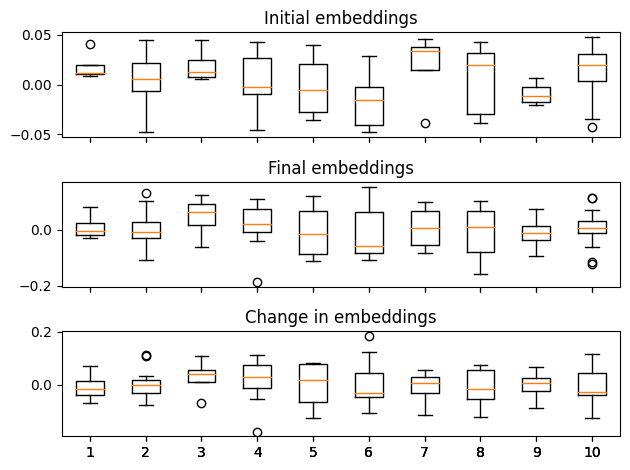

In [9]:
# Inspect final category embeddings
print("Final category embeddings:")
final_embeddings = [x.numpy().copy().squeeze() for x in local_implementation.preprocess_model.embeddings]
print(final_embeddings)
print("Change in category embeddings:")
delta = [(x-y) for x, y in zip(final_embeddings, initial_embeddings)]
print(delta)
# Boxplot for each embedding
# Shared x axis three horizontal plots
# tight_layout() to prevent overlap
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True)

# Plot initial embeddings
axs[0].boxplot([x for x in initial_embeddings])
axs[0].set_title("Initial embeddings")
# Final embeddings
axs[1].boxplot([x for x in final_embeddings])
axs[1].set_title("Final embeddings")
# Change in embeddings
axs[2].boxplot([x for x in delta])
axs[2].set_title("Change in embeddings")
pass

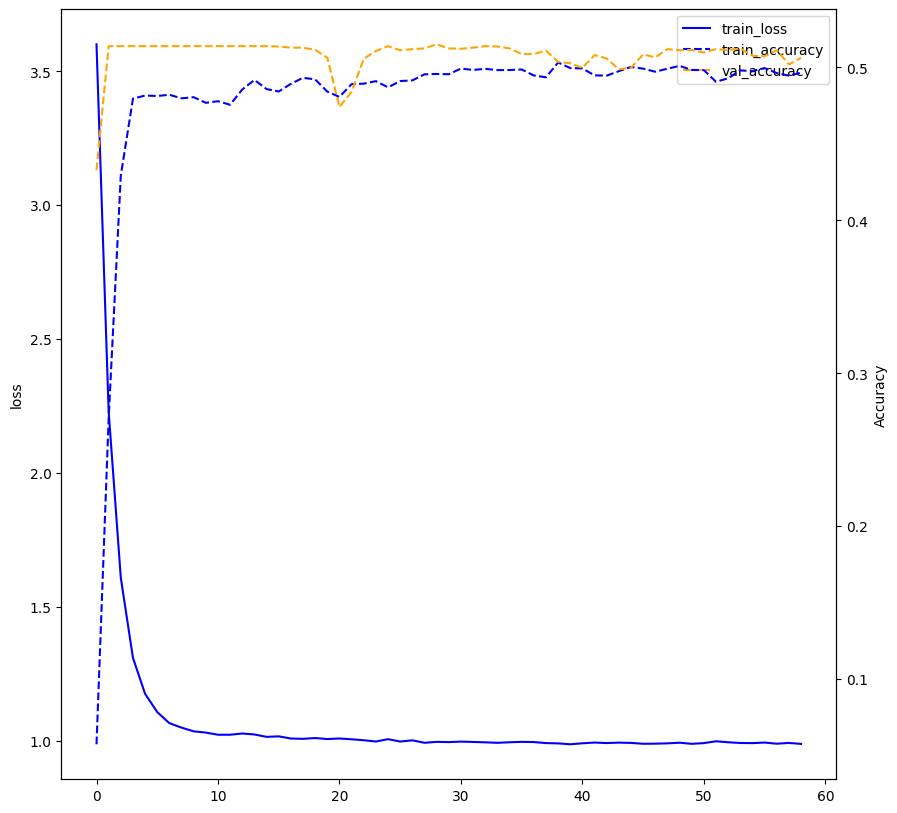

In [10]:
# Plot history loss and RMSE for training and validation set; train solid line, validation dashed line
fig, (top_ax) = plt.subplots(1,1, figsize=(10, 10), sharex=True)

hist = local_implementation.history.history

top_ax.plot(hist['loss'], label='train_loss', c='b')
second_ax = top_ax.twinx()
# Plot precision and recall on second axis in orange and red respectively
second_ax.plot(hist['accuracy'], label='train_accuracy', linestyle='--', c='b')
second_ax.plot(hist['val_accuracy'], label='val_accuracy', linestyle='--', c='orange')
top_ax.set_ylabel('loss')
second_ax.set_ylabel('Accuracy')
# Merge top ax legend entries
handles, labels = top_ax.get_legend_handles_labels()
handles2, labels2 = second_ax.get_legend_handles_labels()
top_ax.legend(handles + handles2, labels + labels2)

In [21]:
# Evaluate model on test set
local_implementation.evaluate(test_dataset)

244/244 [==============================] - 15s 59ms/step - loss: 0.0000e+00 - accuracy: 0.5002


[0.0, 0.5001530647277832]

In [15]:
# Find X_test values that dont fit embedding shapes
for col_idx in range(X_test.shape[1]):
    col = X_test[:, col_idx]
    # Unique values in column
    unique_vals = np.unique(col)
    num_unique_vals = len(unique_vals)

    # Find values that dont fit embedding shapes
    relevant_embedding = local_implementation.preprocess_model.embeddings[col_idx]
    embedding_shape = relevant_embedding.shape[0]
    print("Column: ", col_idx, "Embedding shape: ", embedding_shape)
    print("Unique values: ", unique_vals)
    print("Number of unique values: ", num_unique_vals)
    assert num_unique_vals <= embedding_shape, "Number of unique values in column exceeds embedding shape"

Column:  0 Embedding shape:  4
Unique values:  [1 2 3 4]
Number of unique values:  4
Column:  1 Embedding shape:  13
Unique values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Number of unique values:  13
Column:  2 Embedding shape:  4
Unique values:  [1 2 3 4]
Number of unique values:  4
Column:  3 Embedding shape:  13
Unique values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Number of unique values:  13
Column:  4 Embedding shape:  4
Unique values:  [1 2 3 4]
Number of unique values:  4
Column:  5 Embedding shape:  13
Unique values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Number of unique values:  13
Column:  6 Embedding shape:  4
Unique values:  [1 2 3 4]
Number of unique values:  4
Column:  7 Embedding shape:  13
Unique values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Number of unique values:  13
Column:  8 Embedding shape:  4
Unique values:  [1 2 3 4]
Number of unique values:  4
Column:  9 Embedding shape:  13
Unique values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Number of uniq